# Chapter 5: Factor Models #
&copy; 2019 Kenneth Winston

A fundamental premise of risk modeling is that securities do not move independently of each other. If they did, then buying  $n$ equally-weighted securities would create a portfolio with variance equal to $\frac{1}{n}$ times the average variance, so any sufficiently large portfolio would effectively be risk-free. We saw in Chapter 4 that diversification did lead to lower risk, but it didn't &mdash; and wouldn't, no matter how many securities we chose &mdash; eliminate it.

So there must be common factors that affect all security returns, and that don't diversify away. The [Capital Asset Pricing Model ("CAPM")](#capm), which we'll cover below, is an extreme version of this idea: it states that there is a single source of risk that affects all securities, and all other variation in a security's price is specific to that security and is independent of anything else. For a time, most academic work used the CAPM as the [five-finger assumption](#five_fingers) against which departures, called "anomalies," could be investigated. Since the 1990's, the baseline academic assumption has been a four-factor model ("Fama-French-Carhart") that we'll also describe.

In this chapter we'll also discuss the [Arbitrage Pricing Theory (APT)](#arbitrage_pricing), which is a more general and a more powerful model for the commonalities in security returns than CAPM. Its assumptions are much less restrictive than those required to obtain the CAPM, and much less arbitrary than those in the four-factor model. On the other hand, the APT is so general that it doesn't even specify which common factors affect security returns; it just says they exist.

Practitioners have developed a large number of tools that capture the basic insights of the academic models, while specifying factors and software that allow equity risks to be understood in practice. We will describe some of those models in this chapter.

## 5.1 The Capital Asset Pricing Model and the Four-Factor Model
<a name="capm"></a>

The **`Capital Asset Pricing Model, or CAPM`**, may be the most widely known model from the field of quantitative finance. Despite the fact that empirical tests of the CAPM generally fail to show that it holds in practice, it remains widely popular. The model is variously attributed to Jack Treynor, William Sharpe, John Lintner, and Jan Mossin, who all independently published versions of it in the early 1960s. Sharpe (who had been a PhD student of Harry Markowitz at UCLA) was awarded the [1990 Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel](https://www.nobelprize.org/prizes/economic-sciences/1990/sharpe/facts/) largely for this work.

[Sharpe's 1964 version](https://www.jstor.org/stable/2977928) of the CAPM[$^1$](#five_footnotes) is essentially something we've already seen: Figure 4.6. Sharpe assumed that investors want to choose mean-variance efficient portfolios; that they can borrow and lend at a riskfree rate $r_f$; and that they all agree on the joint probability distribution of asset returns. The last assumption is particularly counterfactual &mdash; investors have wildly different expectations of future returns, volatilities, and correlations. Sharpe acknowledges this is "undoubtedly unrealistic." The hope is that while individual investors may disagree, in aggregate they will act as if they agree.

Under Sharpe's assumptions, everyone will want to be somewhere on the orange line in Figure 4.6. In that case, in equilibrium the tangency portfolio will simply be the market portfolio of all available assets, capitalization-weighted - that is, weighted by how much of each asset is available in the market. Since all investors will hold linear combinations of the risk-free asset and the market porfolios, individual assets will be forced in equilibrium to fall on that line as well. Thus each security $s$'s expected return $r_s$ can be expressed as
$$\mathbb{E}[r_s]-r_f=\beta_s (\mathbb{E}[r_m]-r_f)\label{eq:capm_exact}\tag{5.1}$$
If $\beta_s=0$, then the investor holds only the risk-free asset; if $\beta_s=1$ then the investor holds the market (tangency) portfolio. We must have $\beta_s=\frac{Cov(r_s,r_m)}{Var(r_m)}$.

Removing expectations, the CAPM says we must have
$$r_s-r_f=\beta_s (r_m-r_f)+\epsilon_s\label{eq:capm_general}\tag{5.2}$$
where $Cov(\epsilon_s,r_m)=Cov(\epsilon_s,\epsilon_t)=0$ (for $s\neq t$), and $\mathbb{E}[\epsilon_s]=0$. $\epsilon_s$ is the _idiosyncratic_ or _non-systematic_ behavior of the security, while $r_f+\beta_s(r_m-r_f)$ is the _systematic_ behavior. 

Because of the central role of the beta coefficient, users of the CAPM might simply say they are using betas to describe security behavior.

In the decades since its origin, the CAPM has been massively tested, discussed, modified, and retested. By 1980, Anise Wallace published a cleverly titled article in _Institutional Investor_: "Is Beta Dead?" In corporate finance, betas were (and still are) very much alive for cost-of-capital calculations. In business schools, CAPM is very much alive as it is taught to MBA students as possibly the only market model they need to know.

For portfolio managers composing investment portfolios, beta was never really alive. By assumption the CAPM precludes any systematic ability to beat the market, so active (non-index) investors will find little to help them find superior investments. They can and do use CAPM as a benchmark, but even that use has only weak empirical support.

In academia, debate about CAPM raged on. If the CAPM is correct and the market is the only systematic factor in security returns, we should not be able to observe systematic correlations between $\epsilon_s$ and $\epsilon_t$ for $s\neq t$. A large "anomaly" literature developed showing that certain systematic characteristics could predict security behavior better than the market, so the $\epsilon_s$ were not really independent. For example, in 1981 [Rolf Banz](https://www.sciencedirect.com/science/article/pii/S0304405X11001942) and [Marc Reinganum](https://www.jstor.org/stable/4478439) independently showed the "size anomaly:" small companies behave systematically differently than large companies, in a way that can't be explained by differing betas.

[Fama and French 1992](https://onlinelibrary-wiley-com.clsproxy.library.caltech.edu/doi/epdf/10.1111/j.1540-6261.1992.tb04398.x), and in subsequent papers looked at some previously documented anomalies like company size and "value" (high book-to-price ratios), and defined a three-factor risk model. Later work by [Mark Carhart](https://www.jstor.org/stable/2329556) extended this to what is now the standard academic four-factor equity risk model:
$$r_s-r_f=\beta_{m,s} (r_m-r_f)+\beta_{sz,s}SMB+\beta_{val,s}HML+\beta_{mom,s}UMD+\epsilon_s\label{eq:fama_french_carhart}\tag{5.3}$$
In addition to the familiar market beta (which has been recaptioned $\beta_{m,s}$), three new betas to three new factors are added:
- $\beta_{sz,s}$ is the beta of security $s$ to the size factor $SMB$ ("small minus big"), which captures the difference in returns between a cohort of small stocks and a cohort of big stocks. That is, $\beta_{sz,s}=\frac{Cov(r_s,SMB)}{Var(SMB)}$.
- $\beta_{val,s}$ is the beta of security $s$ to the size factor $HML$ ("high minus low"), which captures the difference in returns between a cohort of high book-to-market ratio stocks and a cohort of low book-to-market ratio stocks.
- $\beta_{mom,s}$ is the factor added due to Carhart's work; it is the beta of security $s$ to the momentum factor $UMD$ ("up minus down"), which captures the difference in returns between a cohort of stocks which have had high momentum over the previous year (i.e. relatively good returns) and a cohort of low momentum stocks.

Most academic work on equity phenomena since the late 1990's has been done with reference to this four-factor model. However it is virtually absent from practitioner work.

# 5.2 Arbitrage Pricing Theory
<a name="arbitrage_pricing"></a>

The Arbitrage Pricing Theory (APT) of Stephen Ross was published in a [1976 paper](https://www.sciencedirect.com/science/article/pii/0022053176900466). We've already seen the Ross Recovery Theorem and the Cox-Ingersoll-Ross short rate model. Ross made these and numerous other contributions to mathematical finance, but when he died on March 3, 2017, his many laudatory obituaries identified him as the "inventor of arbitrage pricing theory."

As the name indicates, APT relies on the principle of arbitrage, or more accurately [no-arbitrage](#no_arbitrage). In particular APT relies on the [Law of One Price](#law_of_one_price) that we saw in Chapter 2; if the same item has two prices then (within the limits of arbitrage such as transactions costs), arbitrageurs will buy the cheaper and sell the dearer until the prices are equalized. Traders speak lovingly of such arbitrage trades and say they will do them "until their fingers bleed," contemplating a lot of furious keyboarding to collect the free money.

## 5.2.1 APT - Exact Form
<a name="exact_apt"></a>

To understand the basic idea of the APT, we start with the following exact equation:
$$r=a+Bf\label{eq:exact_apt_model}\tag{5.10}$$
Here $r$ is an $n$-vector containing the $n$ random variables giving returns over a single period for each of the $n$ assets in the universe. $a$ is a non-stochastic $n$-vector. $B$ is a nonstochastic $n\times k$ matrix, and $f$ is a $k$-vector containing the $k$ random variables giving returns of factors. We can assume that $\mathbb{E}[f]=0$ by shifting $a\rightarrow a+\mathbb{E}[Bf]$ if necessary. So assume $a=\mathbb{E}[r]$.

We called \eqref{eq:exact_apt_model} an exact equation because all of the variation of individual securities on the LHS is exactly explained by the variation of the factors $f$ on the RHS. We'll relax that condition in the next section, but for now note that \eqref{eq:exact_apt_model} is an underdetermined equation. We can "prove" \eqref{eq:exact_apt_model} simply by setting $a=\mathbb{E}[r]$, $f=r-\mathbb{E}[r]$ and $B=I$, $I$ the identity matrix. Clearly there is nothing profound about this. The real insight of the APT is that something like the pricing equation above can work when $k<<n$. The APT therefore contemplates a very small number of systematic, market-wide factors that determine the prices of a very large number of assets. In the [CAPM](#capm), $k=1$ &mdash; the market itself is the only systematic factor. The APT extends that to allow more and different factors.

For example, as we pointed out in Chapter 3, the general level of interest rates is an important factor in an economy. It's plausible that such an important factor would affect most securities in the economy. In that case one of the elements of $f$ might be a random variable giving the general level of interest rates.

So the $f$ vector contains systematic, market-wide factors, while the $B$ matrix contains the sensitivities of individual securities to these factors. The $i^{th}$ row of the $B$ matrix is the set of sensitivities for the $i^{th}$ security. In the CAPM, $B$ was a single vector of betas; in the APT there are “betas” or sensitivities to multiple factors in the columns of $B$. Sometimes these are called “factor loadings.”

Note the APT does not say what the factors are or how many there are. It is completely general in that sense. Ross left it to others (including [himself in later papers](https://www.jstor.org/stable/2352710)) to try to determine plausible sets of factors.

The APT also contemplates a nonstochastic expected return $a_i$ for each security. Ross showed that, under certain conditions, these expected returns are explained (as specified in \eqref{eq:exact_apt_statement} below) by the factor loadings $B$ plus a constant that is essentially a risk-free rate. This anticipated Ross's Recovery Theorem work by almost 40 years, but it has a similar strategy: eliminate unknowns with some clever math.

To prove \eqref{eq:exact_apt_statement}, define a **`hedge portfolio`** as an $n$-vector of weights $h$ with $h^{\prime}u=0$, where as usual $u$ is the unit $n$-vector of all ones. Arbitrage would exist if there were a hedge portfolio $h$ with
$$\mathbb{E}[h^{\prime}r]\neq 0\quad\text{and}\quad Var[h^{\prime}r]=0\label{eq:exact_apt_noarb}\tag{5.11}$$
This says that we could make money with no investment and no risk by investing in $h$ (or –$h$ if the expected value $\mathbb{E}[h^{\prime}r]$ is negative). Since there is no variance, the expected value is the value in all future states of the world. So under no-arbitrage, there must be no portfolio satisfying these conditions.

The argument to prove \eqref{eq:exact_apt_statement} proceeds as follows: We suppose that $n$ is very large compared to $k$. (In other words, we have found a comparatively small number $k$ of systematic factors that explain everything going on in the market.)

Let $A$ be the matrix $(u\enspace B)$; that is, the $n\times (k+1)$ matrix with all ones in the first column and the coefficient matrix $B$ in the remaining $k$ columns. Consider a vector $h$ where $h^{\prime}A=0$.

$h$ is a _factor neutral hedge portfolio_ because the first column of $A$ makes it a hedge portfolio, and the condition $h^{\prime}B=0$ means there are no systematic risks (“factors”) in $h$. Whatever long exposure $h$ has to any of the systematic factors (i.e. the sum of the positive entries in $h$) is offset by an exactly equal short exposure (i.e. the sum of the negative entries in $h$). Since our model has no non-systematic behavior, there is nothing left over. If we left-multiply \eqref{eq:exact_apt_model} by $h^{\prime}$, we get
$$h^{\prime}r=h^{\prime}a+(h^{\prime}B)f=h^{\prime}a\label{eq:exact_apt_hedge}\tag{5.12}$$

$h$ requires no investment ($h^{\prime}u=0$) and has no risk because taking $Var$ of both sides of \eqref{eq:exact_apt_hedge} shows that $Var[h^{\prime}r]=Var[h^{\prime}a]=0$ because $h^{\prime}a$ is a constant. So the no-arbitrage condition \eqref{eq:exact_apt_noarb} tells us its expected value (that is, $h^{\prime}a=\mathbb{E}[h^{\prime}r])$ is zero. Another way of saying this is that if $h$ is a factor-neutral hedge portfolio, then $\mathbb{E}[r]$ is in the null space of $h$, $\mathbb{E}[r]\in N(h)$.

More generally, the columns of $A$ form a vector space $c(A)$, and the (left) null space of $A$ forms another vector space $N(c(A))$. That is, $h\in N(c(A))\iff  h^{\prime}w=0 \quad\forall w\in c(A)$. Consider the null space of the null space, $N(N(c(A))$. This is the collection of vectors $z$ with $z^{\prime}h=0$ whenever $h\in N(c(A))$. It can be shown that $N(N(c(A)))=c(A)$.

From the line of reasoning above, and the fact that $h^{\prime}\mathbb{E}[r]=0$, we see that $\mathbb{E}[r]\in N(N(c(A)))=c(A)$, so $\mathbb{E}[r]$ is a linear combination of the columns of $A$:
$$a=\mathbb{E}[r]=r_f u+B\lambda\label{eq:exact_apt_statement}\tag{5.15}$$
\eqref{eq:exact_apt_statement} is what is usually called the _Arbitrage Pricing Theory_; it is the generalization of CAPM's \eqref{eq:capm_exact}. Here $\lambda$ is a $k$-vector of scalars and $r_f$ is a scalar. If there is a risk-free asset, then $r_f$ is the risk-free rate since the factor loadings for the risk-free asset are zeroes. In other words, the row of $B$ corresponding to the risk-free asset is a row of zeroes. Otherwise $r_f$ is an arbitrary scalar. The $\lambda$‘s are called the **`prices of risk`** for each of the $k$ factors.

The linear form of the APT, together with the dimensions ($n>>k$), indicates that we can price excess expected returns solely by reference to their loadings on systematic factors.

## 5.2.2 APT - Inclusion of specific behavior

The exact equation \eqref{eq:exact_apt_model} was oversimplified; it didn't allow for idiosyncratic behavior, i.e. behavior that is independent of systematic factors. For example, if the head of an electric car company tweets about a possible stock buyout and the company's price jumps, that may have nothing to do with the overall economy; with the rest of the automobile industry; or with any other identifiable systematic factor.

We can take into account such **`idiosyncratic`** or **`specific`** behavior by introducing a new term to \eqref{eq:exact_apt_model}:
$$r=a+Bf+\epsilon\label{eq:general_apt_model}\tag{5.20}$$
$\epsilon$ takes into account CEO tweeting and other independent behavior; it is a random $n$-vector where $\mathbb{E}[\epsilon_i \epsilon_j]=\mathbb{E}[\epsilon_i f_m]=\mathbb{E}[\epsilon_i]=0\enspace\forall i,m,j\neq i$. We can assume as in the [exact APT development](#exact_apt) that $\mathbb{E}[f]=0$ and $a=\mathbb{E}[r]$. \eqref{eq:general_apt_model} is the generalization of the Capital Asset Pricing Model's \eqref{eq:capm_general}.

As we noted after \eqref{eq:exact_apt_model}, \eqref{eq:general_apt_model} is trivially true. While \eqref{eq:exact_apt_statement} contains some clever reasoning, \eqref{eq:exact_apt_model} and \eqref{eq:general_apt_model} are just statements about how we intend to think about things and are not theorems.

For the exact equation \eqref{eq:exact_apt_model}, the result was that $a=A\lambda$ for some $(k+1)$-vector $\lambda$, where $A$ was the $B$ matrix prepended by the $u$ vector. For the APT with nonsystematic behavior included, the result is less exact and is stated in the limit as the number $n$ of securities in the market goes to infinity.

The generalization of \eqref{eq:exact_apt_statement} that we seek to prove under model \eqref{eq:general_apt_model} (and no-arbitrage) says that with no-arbitrage, there is a constant $c$ such that no matter how big the number of assets $n$ gets, we can find a $(k+1)$-vector $\lambda$ so that
$$(a-A\lambda)^{\prime}(a-A\lambda)\leq c\label{eq:general_apt_price_error}\tag{5.21}$$
The n-vector $(a-A\lambda)$ is called the **`pricing error`** and is the “miss” in the factor model – it is the deviations in expected returns that can’t be explained by the factors (and a constant). In the exact form, we were able to eliminate pricing error ($c=0$). \eqref{eq:general_apt_price_error} doesn't eliminate pricing error, but it does say that the factor model pricing error is bounded in some sense even for a very large number of securities.

To prove \eqref{eq:general_apt_price_error}, note first that as a result of \eqref{eq:general_apt_model} and the assumptions after it, we can write
$$Var[w^{\prime}r]=\mathbb{E}[\bigl(w^{\prime}r-w^{\prime}\overline{r}\bigr)^2]
=\mathbb{E}[w^{\prime}\bigl(r-\overline{r}\bigr)\bigl(r^{\prime}-\overline{r}^{\prime}\bigr)w]$$
$$=w^{\prime}Var[r]w=w^{\prime}Var[Bf]w+w^{\prime}Var[\epsilon]w
=w^{\prime}B^{\prime}Var[f]Bw+w^{\prime}Var[\epsilon]w\label{eq:general_apt_covar}\tag{5.22}$$
for any portfolio $w$.

Thus if we estimate the $k\times k$ factor covariance matrix $Var(f)$ – a much easier proposition than directly estimating the $n\times n$ full covariance matrix $Var(r)$ – we have under APT obtained the full covariance matrix except possibly for a diagonal matrix of specific (or residual, or idiosyncratic) risks.

If the model \eqref{eq:general_apt_model} has any value, the residual risks in the vector $\epsilon$ shouldn’t be too big. Contrapositively, if the residuals dominate the risks explained by the factors, then \eqref{eq:general_apt_model} has no content. This is similar to the idea that \eqref{eq:exact_apt_model} has no content if n isn’t much bigger than k, the number of factors.

Thus we further assume that the variances of the residuals are bounded above, so that for all i,
$$Var(\epsilon_i)<S^2$$
for some constant S.

The bounded nature of residual variance is perhaps the key requirement. Intuitively it says that whatever is left over after the factor behavior is removed can’t be too important. While the pricing equation \eqref{eq:general_apt_model} is completely arbitrary, once we
1. restrict the number $k$ of systematic factors to be very small; and
2. restrict the residual variances

we are imposing a view of the world on asset pricing – namely that the small number of factors essentially controls pricing.

[Gar Huberman](https://www.sciencedirect.com/science/article/pii/0022053182900989), a student of Stephen Ross, noted the following. He strengthened the no-arbitrage condition \eqref{eq:exact_apt_noarb} slightly to say that there can be no sequence of hedge portfolios $h_1,\dots,h_j,\dots$ such that
$$\lim_{j\to\infty}\mathbb{E}[h_j^{\prime}r]=\infty\enspace\text{and}\enspace\lim_{j\to\infty}Var[h_j^{\prime}r]=0\label{general_apt_noarb}\tag{5.23}$$
If there is a portfolio $h$ satisfying \eqref{eq:exact_apt_noarb}, then the sequence $h_j=j\cdot h$ (or $-h_j$) satisfies \eqref{general_apt_noarb}. The contrapositive of that implication is that the nonexistence of \eqref{general_apt_noarb} sequences implies the nonexistence of \eqref{eq:exact_apt_noarb} hedge portfolios, so the \eqref{general_apt_noarb} nonexistence is the stronger condition.

The LHS of the desired inequality \eqref{eq:general_apt_price_error} is the square of the $\mathscr{L}^2$-norm of the pricing miss. We can minimize that by finding $\lambda_{min}$:
$$\lambda_{min}=\text{argmin}{(a-A\lambda)^{\prime}(a-A\lambda)}\label{eq:general_apt_lambda_min}\tag{5.25}$$

To find $\lambda_{min}$, we take the derivative of the RHS of \eqref{eq:general_apt_lambda_min} with respect to $\lambda$ and set it to zero:
$$A^{\prime}(a-A\lambda_{min})=0\label{eq:general_apt_null_cond}\tag{5.26}$$

Let $h_{min}=a-A\lambda_{min}$ be the optimal pricing miss. Then \eqref{eq:general_apt_null_cond} tells us that $A^{\prime}h_{min}=0$ so $h_{min}$ is a factor neutral hedge portfolio. The expected return on $h_{min}$ is
$$\mathbb{E}[h_{min}^{\prime}r]=h_{min}^{\prime}a\tag{5.27}$$
since $a=\mathbb{E}[r]$. Since $A$ is in the null space of $h_{min}$, we can change the rightmost $a$ to $a-A\lambda_{min}$:
$$\mathbb{E}[h_{min}^{\prime}r]=h_{min}^{\prime}h_{min}\label{eq:general_apt_mean}\tag{5.28}$$

The variance of $h_{min}$'s return is
$$Var[h_{min}^{\prime}r]=h_{min}^{\prime}Var[\epsilon]h_{min}\tag{5.29}$$
Here we have used \eqref{eq:general_apt_covar} and the fact that $A^{\prime}h_{min}=0$ so $B^{\prime}h_{min}=0$. Our assumptions indicate that the $Var[\epsilon]$ matrix is diagonal and that each term is bounded above by $S^2$, so
$$Var[h_{min}^{\prime}r]\leq S^2h_{min}^{\prime}h_{min}\label{eq:general_apt_variance}\tag{5.30}$$

The desired inequality \eqref{eq:general_apt_price_error} contemplates an ever-growing number of assets, so the optimal pricing miss $h_{min}$ is actually $h_{min}(j)$, where $j$ is the number of assets in the iteration. Set
$$s(j)=\bigl(h_{min}(j)^{\prime}h_{min}(j)\bigr)^{-3/4}\label{eq:general_apt_sofj}\tag{5.31}$$
and define $h_j=s(j)h_{min}(j)$. The $h_{min}(j)^{\prime}h_{min}(j)$ expression on the RHS of \eqref{eq:general_apt_sofj} was already present (with implicit $j$) in the mean and variance expressions \eqref{eq:general_apt_mean} and \eqref{eq:general_apt_variance}, so we can write
$$\mathbb{E}[h_j^{\prime}r]=s(j)\mathbb{E}[h_{min}(j)^{\prime}r]=
\bigl(h_{min}(j)^{\prime}h_{min}(j))\bigr)^{1/4}\label{eq:general_apt_mean_limit}\tag{5.32a}$$
$$Var[h_j^{\prime}r]=s(j)^2Var[h_{min}(j)^{\prime}r]\leq S^2\bigl(h_{min}(j)^{\prime}h_{min}(j)\bigr)^{-1/2}\label{eq:general_apt_variance_limit}\tag{5.32b}$$

Consider the sequence of $h_j$'s in the context of the no-arbitrage conditions \eqref{general_apt_noarb}. The expression $h_{min}(j)^{\prime}h_{min}(j)$ is the LHS of \eqref{general_apt_noarb}; if it gets bigger and bigger as the number of assets grows, then \eqref{eq:general_apt_mean_limit} and \eqref{eq:general_apt_variance_limit} show that \eqref{general_apt_noarb} will be violated. That can't happen, so $h_{min}(j)^{\prime}h_{min}(j)$ is bounded as desired and the APT is proved.

The APT is in some sense far more powerful than the CAPM. It rests almost entirely on the assumption that the market is driven by a small number of factors &mdash; from that basic assumption (and no-arbitrage) the rest is logical reasoning. Of course the precise form of that basic assumption (a stationary linear relationship) is also important, but it is less restrictive than the CAPM's assumption that market participants are mean-variance optimizers.

On the other hand, the APT is silent on what the factors are. Subsequent to its publication, many investigators attempted to determine plausible sets of factors. One line of investigation is exemplified by [Chen, Roll & Ross 1986](https://www.jstor.org/stable/2352710), who concluded that macroeconomic factors – inflation surprise, industrial production, interest rates, credit spreads, and the level of the equity market – were the appropriate factors. The last factor is in effect the CAPM factor. While such macroeconomic factors seem to give a broad historical view of asset relationships &mdash; they seem to get things right over decades &mdash; few practitioners use them in day-to-day risk management.

## 5.3 Factor Models in Practice ##

A line of investigation that is more popular with market participants is exemplified by [Rosenberg and Marathe 1976](https://econpapers.repec.org/paper/ucbcalbrf/44.htm), who used microeconomic factors to drive the equity market. Rosenberg went on to form a company called BARRA ("Barr Rosenberg Associates") that offered equity risk models. Over the years, these kinds of factors included
- Industry or industrial sector
- Country or region (for multinational portfolios)
- Price ratio factors; book/price, earnings/price, dividend/price, free cash flow/price, sales/price…
- Company size (market capitalization)
- Price momentum, earnings momentum &mdash; as well as price reversals and earnings reversals over different periods.
- Financial leverage (debt/equity ratio); capital expenditures

BARRA was acquired in 2004 by another company, [MSCI](https://www.msci.com/our-story), which now sells the current versions of these factor-based risk models. Competitors like [Axioma](https://www.axioma.com/) and [Northfield](http://www.northinfo.com/) also offer equity factor models.

Testing the APT is difficult: then main problem is it only works as $n\to\infty$. We can try to gather a large number of assets on which to test APT, but we can’t be sure we have enough since we’ll never get to infinity. What we leave out might be crucial.

We can make informal tests simply by doing regressions. If we are able to identify a set of factors – whether macroeconomic, company-specific, or based on principal component analysis – then we can look at the residuals after the systematic portion based on the factors is removed. If these residuals are small, then we have anecdotal but not conclusive evidence of a good model. More importantly, if the out of sample residuals are small then we have informal evidence of having captured a market dynamic.

While it is often possible to obtain reduction in residuals after taking out factors, it appears that factors and their loadings are unstable over time, making it impossible to estimate static long-term parameters. However over shorter periods of time residual reduction can be found.

The main practical implementation of the APT is \eqref{eq:general_apt_price_error} – that is, the model for the covariance matrix. Stripping out the portfolio vector, we can just write:
$$C=BFB^{\prime}+D\label{eq:factor_practice}\tag{5.40}$$
Here $C$ is the $n\times n$ covariance matrix, where the $(i,j)$ entry is the covariance between asset $i$ and asset $j$. $B$ is an $n\times k$ matrix, where $k<<n$. $F$ is the $k\times k$ factor covariance matrix, which is assumed to be much easier to estimate and predict than $C$ directly. $D$ is a diagonal matrix of individual asset residual variances.

In the Rosenberg and Marathe 1976 approach, $B$ is determined by looking at the characteristics of the asset. For example, the rows of $B$ might be of size $k=100$ with the first 50 columns being mostly zeroes. These 50 columns indicate what industries the company does business in, with a complicated company like Amazon having as many as 5 nonzero entries (such as cloud services, online retail, etc.). The other entries might be things like company size (the logarithm of the company’s stock market capitalization); its earnings momentum, and other factors from the list above. The non-industry items might be standardized across the universe so that they average zero in every cross-section and have a cross-sectional standard deviation of one. They might also be Winsorized[$^2$](#five_footnotes) at around $\pm4.5$.

The general idea is that the relationships between the $k=100$ factors are more stable than the relationships between the (say) $n=8000$ assets. For example, the relationship between the energy industry and the aircraft manufacturing industry is probably more stable than the relationship between Boeing and Exxon-Mobil. The relationship between “value” companies with high book/market ratios and “small” companies with low market capitalizations is (the theory goes) more stable than the relationship between any two such companies.

The residual (the diagonal entries of D) is used to account for company-specific or idiosyncratic behavior. For example, there is very little difference between Royal Dutch Shell and Exxon-Mobil in terms of systematic exposures: they are both large, multinational &mdash; the fact that one is headquartered in the US and the other in Europe is not particularly important given their global reach &mdash; integrated energy companies. Any differences in their returns behavior is most likely due to some specific factors – say Exxon-Mobil is drilling a particular well that Shell is not.

The residual variance in $D$ can be computed by looking at the variance of the difference between the asset’s actual time series of returns (often over the last five years monthly) minus the returns that would have been produced by multiplying the factor loadings times the returns on the underlying factors (energy industry, large-cap companies, etc.). Or residual variance can itself be modeled.


## 5.4 Principal Components Analysis ##

Another approach to modeling covariance matrices is principal components analysis ("PCA"). Since covariance matrices are square symmetric real-valued positive semidefinite matrices, principal components analysis simply involves finding eigenvalues and eigenvectors. We'll review that briefly and then return to the financial application.

If $M$ is a matrix (for simplicity we’ll assume herein that $M$ is $n\times n$ square and symmetric), a scalar $\lambda$ such that there exists a nonzero vector $v$ with
$$Mv=\lambda v\tag{5.41}$$
is called an _eigenvalue_ (or _characteristic value_) of $M$, and the $n$-vector $v$ is $\lambda$’s associated eigenvector. Note that any scalar multiple of an eigenvector is an eigenvector associated with the same eigenvalue; we often require that $v^{\prime}v=1$ to normalize the eigenvector. The defining equation for eigenvalues can be rewritten
$$(M-\lambda I)v=0\tag{5.42}$$
From basic matrix theory, we know this means $M-\lambda I$ is singular, which means
$$det(M-\lambda I)=0\tag{5.43}$$
This equation becomes a polynomial in $\lambda$ of order up to $n$; it is called the characteristic equation of $M$. Every solution to the characteristic equation is an eigenvalue, and vice versa.

The reader should be able to show that
>The product of all eigenvalues of a matrix equals the matrix's determinant.

Thus a matrix is nonsingular if and only if none of its eigenvalues is zero. A matrix is positive (semi)definite if for any vector $x\neq 0$, we have $x^{\prime}Mx\geq0$, with strict inequality removing the “(semi).” If the matrix is positive definite (semidefinite), then all the eigenvalues are positive (nonnegative).

The reader should also be able to show that
>The sum of all eigenvalues of a matrix equals the matrix’s trace.

If $M$ is a real symmetric nxn matrix of rank $r$, then the [spectral theorem](https://www.jstor.org/stable/2313117) says that we can write
$$M=EGE^{\prime}\enspace\text{where}\enspace E^{\prime}E=I\enspace\text{and G is diagonal}\label{eq:pca_eigendecomposition}\tag{5.44}$$
$E$ is $n\times r$ and $G$ is $r\times r$. If $M$ is of full rank (nonsingular), then $E$ is a square matrix and $E^{\prime}=E^{-1}$. The decomposition \eqref{eq:pca_eigendecomposition} is called an **`eigendecomposition`** or **`spectral decomposition`**. It is also called **`principal components analysis (PCA)`**. PCA assumes that the eigenvectors associated with the larger eigenvalues of a covariance matrix are the more important, lasting ones. 

We will be interested in applying PCA to covariance and correlation matrices. (If $S$ is the diagonal matrix whose diagonal entries equal the square roots of the diagonal entries of a covariance matrix $C$, then the correlation matrix $R=S^{-1}CS^{-1}$). Sample covariance and correlation matrices observed from time series data are positive semidefinite by construction.

The eigenvectors associated with the smaller eigenvalues are **`scree`**, a word from geology that means debris. A **`scree plot`** shows the percentage of the trace represented by the eigenvalues of a matrix, in descending order. For example the eigenvalue percentages for a currency covariance matrix looks like this:

<function matplotlib.pyplot.show(*args, **kw)>

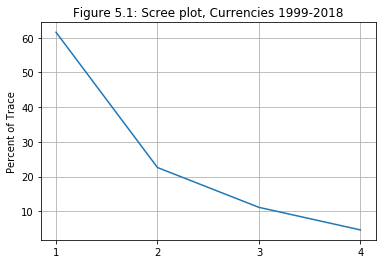

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import qrbook_funcs as qf
#Get 4 currencies until the end of
#previous year. Form sample covariance matrix

firstday='1999-01-04'
lastday=qf.LastYearEnd()
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS','DEXUSEU']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
            startdate=firstday,enddate=lastday)

#Convert levels to log-returns
#First take logs of the currency levels
#Currency exchange rates are usually expressed in the direction
#that will make the rate > 1
#Swissie and yen are in currency/dollar, but
#pounds and euros are in dollar/currency. Reverse signs
#so everything is in dollar/currency

#Do each currency separately to account for separate missing data patterns
#dlgs is a list of lists of length 4 corresponding to the 4 currencies
#The value in dlgs is nan if there is missing data for the present or previous day's observation
#Otherwise it is the log of today/yesterday
multipliers=[-1,1,-1,1]
dlgs=[]
for i in range(len(multipliers)):
    lgrates=[]
    previous=-1
    for t in range(len(ratematrix)):
        if pd.isna(ratematrix[t][i]) or ratematrix[t][i]<=0:
            lgrates.append(np.nan)    #Append a nan
        else:
            if previous < 0:    #This is the first data point
                lgrates.append(np.nan)
            else:
                lgrates.append(np.log(ratematrix[t][i]/previous)*multipliers[i])
            previous=ratematrix[t][i]
    dlgs.append(lgrates)

#dlgs is the transpose of what we want - flip it
dlgs=np.transpose(dlgs)

#Delete any time periods that don't have data
lgdates=[]
difflgs=[]
for t in range(len(dlgs)):
    if all(pd.notna(dlgs[t])):
        #include this time period
        difflgs.append(dlgs[t])
        lgdates.append(cdates[t])

#compute covariance matrix
c=np.cov(np.array(difflgs).T)

#get eigenvalues and eigenvectors
evals,evecs=np.linalg.eig(c)
#Put the eigensystem in decreasing
#order of eigenvalues
sortorder=evals.argsort()[::-1]
evals=evals[sortorder]
evecs=evecs[:,sortorder]

#Make the scree plot
plt.plot(range(1,5), list(evals*100/sum(evals)))
## Configure the graph
plt.title('Figure 5.1: Scree plot, Currencies 1999-'+lastday[:4])
plt.ylabel('Percent of Trace')
plt.xticks(range(1,5),range(1,5))
plt.grid(True)
plt.show

The covariance matrix in Figure 5.1 used the three currencies (Swissie, Pound, Yen) we used in Chapter 4, plus the Euro. This plot shows a typical pattern where the eigenvalues drop in size: it is rare that they are close to equal. Usually as the size of the matrix increases, we see that a small number of eigenvalues account for most of the trace, after which there is an inflection point and the sizes of the eigenvalues drop sharply.

Financial econometricians have taken the dropoff in eigenvalues as evidence that the Arbitrage Pricing Theory is true. [Trzcinka 1986](https://www.jstor.org/stable/2328440) summarized his results as follows:
>We compute sample [stock market] covariance matrices of returns in sequentially larger portfolios of securities. Analyzing their eigenvalues, we find evidence that one eigenvalue dominates the covariance matrix indicating that a one-factor model may describe security pricing... We find that while only the first eigenvalue dominates the matrix, the first five eigenvalues are growing more distinct.

The dominance of the first eigenvalue seems to be replicable; other markets and other time periods than the ones used by Trzcinka &mdash; including our Figure 5.1 and yield curve data in Figure 3.10 &mdash; show a similar pattern. Trzcinka conluded that there wasn't strong evidence of another obvious inflection point after the first eigenvalue, but thought that there was weak evidence of an inflection point after the fifth eigenvalue.

Unfortunately a concentration in larger eigenvalues is not necessarily evidence of underlying factor structure: it may just be random. Sample covariance matrices look like $C=\frac{1}{T}R^{\prime}R$, where $R$ is an $n\times T$ matrix of de-meaned returns of $n$ securities over $T$ time periods. Marchenko and Pastur[$^3$](#five_footnotes) found the distribution of the sizes of eigenvalues of $C$; it is heavily front-loaded when $R$ is randomly generated. Front-loading of observed market covariance matrices is, however, even more concentrated than random matrix theory's distribution.

PCA’s strength – as well as its weakness – is that it requires no judgment about the data. The Rosenberg-Marathe approach used in most commercial models requires judgment about which characteristics of a security are the important, lasting ones. If these judgments are right, then the model will do a good job predicting future covariance matrices. But as markets change, these models might not keep up. For example, most commercial models didn’t have an Internet factor in the late 1990s, although the technology bubble (and its bursting) made Internet companies behave distinctly differently than other companies in that period.

Because PCA infers factors from the data, it is able to discover patterns that human analysts may not see. However, there are some disadvantages to this approach:
- PCA is backward-looking. It cannot “see” a pattern until it is in the data. Similarly, it cannot drop a pattern that is no longer relevant until it drops out of the data. For example, in the runup to the US invasion of Iraq in 2003, virtually the only factor that mattered in the US stock market was a security’s relationship to the impending war. After the invasion of Iraq on March 20, 2003, this factor quickly became irrelevant. However a model with (say) a trailing 3-year data window would not “know” this for 3 years.
- The backward-looking problem would not be a problem if principal components were stable through time. However usually they are not – a PC that was present in the data in the last 3 years may disappear completely in the next three years. For this reason some practitioners use PCA as a forensic tool (helping to alert humans to patterns that may be emerging in the data) as opposed to a model.
- PCA factors are hard or impossible for humans to understand.

To see the time variation in eigenvalues and eigenvectors, let's compare the $4\times 4$ covariance matrix behind Figure 5.1 (taken over the period 1999 (when the Euro began) to the most recent yearend) with the same currencies from the turbulent year 2008.

In [3]:
#Display the 4x4 covariance matrix
np.set_printoptions(precision=4,floatmode='fixed',sign=' ')
print('1999-'+lastday[:4]+' covariance matrix (Cfull): (%d days)' % len(difflgs))
print('     CHF     GBP     JPY     EUR')
for i in range(4):
    print(c[i]*10000)

#Compute 2008 covariance matrix
s2008=lgdates.index('2008-01-02')
e2008=lgdates.index('2008-12-31')
c2008=np.cov(np.array(difflgs[s2008-1:e2008+1]).T)
#Display the 4x4 covariance matrix
print('2008 covariance matrix (C2008):')
for i in range(4):
    print(c2008[i]*10000)

1999-2018 covariance matrix (Cfull): (5021 days)
     CHF     GBP     JPY     EUR
[ 0.4742  0.2053  0.1693  0.3357]
[ 0.2053  0.3496  0.0516  0.2327]
[ 0.1693  0.0516  0.4206  0.1130]
[ 0.3357  0.2327  0.1130  0.3808]
2008 covariance matrix (C2008):
[ 0.9045  0.3453  0.3816  0.6867]
[ 0.3453  0.9142 -0.2797  0.5875]
[ 0.3816 -0.2797  0.9572  0.0110]
[ 0.6867  0.5875  0.0110  0.8044]


We can clearly see the effects of the financial crisis in 2008: the diagonals of C2008 are larger than the diagonals of Cfull by about a factor of two - i.e. volatility was higher in 2008.

Let’s look at the eigensystems of these matrices. The eigenvalues and eigenvctors for Cfull were:

In [4]:
#Display the eigenvalues
print('Full period eigenvalues times 10**6:')
print(evals*1000000)

#Display the eigenvectors
print('Eigenvector (column) matrix:')
labels=['CHF','GBP','JPY','EUR']
for i in range(4):
    print(labels[i],evecs[i])

Full period eigenvalues times 10**6:
[ 100.0800   36.7554   18.1247    7.5645]
Eigenvector (column) matrix:
CHF [ 0.6293 -0.0247  0.5505  0.5480]
GBP [ 0.4249 -0.3883 -0.7719  0.2699]
JPY [ 0.3306  0.8976 -0.2872 -0.0506]
EUR [ 0.5605 -0.2073  0.1365 -0.7901]


The first column of the eigenvector matrix is the one associated with the largest eigenvalue. All the entries are positive and are roughly the same order of magnitude. There's no guarantee that an eigenvector will have any intuitive meaning, but in this case it's pretty clear what the largest factor is: it's the US dollar, since all these exchange rates were versus the US dollar.

The second column of the eigenvector matrix might be Europe vs. Japan, but we're just guessing. We only have 4 items in our universe here; imagine if there were 4000 items. It would be very tough to find an intuitve explanation of 4000 numbers.

Here's the eigensystem of the 2008 covariance matrix:

In [5]:
#get eigenvalues and eigenvectors of the 2008 matrix
evals2008,evecs2008=np.linalg.eig(c2008)
#Put the eigensystem in decreasing
#order of eigenvalues
sortorder2008=evals2008.argsort()[::-1]
evals2008=evals2008[sortorder2008]
evecs2008=evecs2008[:,sortorder2008]

#Display the 2008 eigenvalues
print('2008 eigenvalues times 10**6:')
print(evals2008*1000000)

#Display the 2008 eigenvectors
print('2008 eigenvector (column) matrix:')
for i in range(4):
    print(labels[i],evecs2008[i])

2008 eigenvalues times 10**6:
[ 196.6205  125.9944   27.9513    7.4675]
2008 eigenvector (column) matrix:
CHF [ 0.5949  0.3290  0.3950 -0.6178]
GBP [ 0.5133 -0.4496 -0.7044 -0.1956]
JPY [ 0.0894  0.8280 -0.5177  0.1960]
EUR [ 0.6120 -0.0638  0.2824  0.7359]


The overall volatility has gone up a lot as previously noted. The first principal component now seems to be mostly European currencies vs. the dollar, whose role as a safe haven currency was even more important in 2008. The second principal component has become more important than in the full matrix (i.e. eigenvalue is larger both on an absolute basis and as a percentage of the total). The second PC now appears to be currencies that were considered safe havens (Swissie and yen) vs. less safe-haven currencies (pound and euro).

Often PCA is used for data reduction. So for example based on the scree plot 5.1 we might have concluded that the vast majority of the currency covariance matrix was explained by the first two principal components. An approximation to a currency covariance matrix based on this idea would be $E_2G_2E_2^{\prime}$, where $E_2$ is the first two columns of the $E$ in (5.51) (i.e. a $4\times 2$ matrix) and $G_2$ is a diagonal matrix containing the associated eigenvalues (i.e. a $2\times 2$ matrix).

The code in the next cell computes covariance matrices based on fewer eigenvalues. Use the slidebar to change the number used, and compare to the original:

In [6]:
#Compute and display the currency covariance matrix
#based on fewer principal components
from ipywidgets import interact

def display_trunc(n_2_use=2):
    #Display covariance matrix with truncated eigensystem
    
    #Round to integer
    num_2_use=int(n_2_use)
    
    #Form truncated diagonal matrix G of eigenvalues
    g_trunc=np.diag(evals)[:num_2_use]
    del_cols=np.arange(num_2_use,len(evals))
    g_trunc=np.delete(g_trunc,del_cols,1)

    #Form truncated matrix E_k of eigenvectors
    e_trunc=np.delete(evecs,del_cols,1)

    c_trunc=np.matmul(np.matmul(e_trunc,g_trunc),e_trunc.T)

    print('Original covariance matrix:')
    print('     CHF     GBP     JPY     EUR')
    for i in range(4):
        print(c[i]*10000)
    print('Truncated covariance matrix:')
    for i in range(4):
        print(c_trunc[i]*10000)
        
interact(display_trunc, n_2_use=(1.0, 4.0, 1.0));

interactive(children=(FloatSlider(value=2.0, description='n_2_use', max=4.0, min=1.0, step=1.0), Output()), _d…

The matrices don't look to be very different by the time two PCs are used, confirming at least intuitively that the significant movements are in the earlier principal components.

Current commercial risk models may use a hybrid approach, where a specified factor model like \eqref{eq:fama_french_carhart} &mdash; or the richer 100-factor models used in practice &mdash; is applied first. The residuals $\epsilon_s$ from \eqref{eq:fama_french_carhart} (or its commercial big brother) are computed for each security in each time period, typically for sixty months. The residuals are then used to form a residual covariance matrix, and PCA is applied to that matrix. If it looks like there is a large common factor in the residual covariance, the model \eqref{eq:fama_french_carhart} must be misspecified. This process can be used as a forensic tool to guide intuition to find missing factors, or it can be used to add residual PCA factors to the risk model.

# Chapter 5 Footnotes #
<a name="five_footnotes"></a>

$^1$ In a footnote, Sharpe says "After preparing this paper the author learned that Mr. Jack L. Treynor, of Arthur D. Little Inc., had independently developed a model similar in many respects to the one described here. Unfortunately Mr. Treynor's excellent work on this subject is, at present, unpublished."

$^2$ Winsorization (named after biostatistician Charles Winsor) is a truncation process by which outlying data is moderated. A parametric version of the process caps observations at some maximum or minimum numerical amount, so for example any observation over 4.5 would be deemed to equal 4.5. A non-parametric version sorts observations from lowest to highest and then sets (say) the lowest and second-lowest observations equal to the third-lowest observation.

$^3$ Nicu and Speicher, _Lectures on the Combinatorics of Free Probability_, https://www.google.com/search?tbs=bks:1&q=isbn:0521858526, p. 368.